# **데이터셋 1 전처리**

# 1차

- 울릉도 데이터 제거
- 컬럼명 한글 → 영어 (데이터셋2와 변수명 통일)
- 결측치 및 이상치 처리
- 연도, 월 나누기
- 월 → 범주형 인코딩
- 시군별 데이터를 연/월별 평균값으로 통일
- 월합강수량 → 일평균 강수량으로 변환
- 기온차(temp_range) 변수 생성 (최고기온 - 최저기온)

## 가은

### 1. 데이터프레임의 행과 열 파악

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [ ]:
root_dir = "/content/drive/MyDrive/Data Science Team Project"

file_path = os.path.join(root_dir, '경북 월별 기상 관측 자료.csv')

KBWeather_df = pd.read_csv(file_path, encoding='cp949')

print(KBWeather_df.columns)        # 열 이름 출력
print("\n", KBWeather_df['지점명'].drop_duplicates())  # 지점명 출력


Index(['지점', '지점명', '일시', '평균최고기온(°C)', '평균최저기온(°C)', '월합강수량(00~24h만)(mm)',
       '평균풍속(m/s)'],
      dtype='object')

 0       울릉도
1041     울진
1693     안동
2265     상주
2545     포항
3456     봉화
3904     영주
4534     문경
5164    청송군
5340     영덕
5968     의성
6596     구미
7224     영천
7852    경주시
Name: 지점명, dtype: object


### 2. 필요 없는 행, 열 제거


*   울릉도 데이터 제거
*   '지점' 열 제거



In [ ]:
KBWeather_df = KBWeather_df[~KBWeather_df['지점명'].isin(['울릉도'])]  # 울릉도 데이터 제거
print(KBWeather_df['지점명'].drop_duplicates())  # 지점명 출력

del KBWeather_df['지점']  # '지점' 열 제거
print("\n", KBWeather_df.columns)  # 열 이름 출력

1041     울진
1693     안동
2265     상주
2545     포항
3456     봉화
3904     영주
4534     문경
5164    청송군
5340     영덕
5968     의성
6596     구미
7224     영천
7852    경주시
Name: 지점명, dtype: object

 Index(['지점명', '일시', '평균최고기온(°C)', '평균최저기온(°C)', '월합강수량(00~24h만)(mm)',
       '평균풍속(m/s)'],
      dtype='object')


### 3. 컬럼명 한글 → 영어 (데이터셋2와 변수명 통일)

In [ ]:
# --------------------------------------------
# 1. 컬럼명 한-영 변환
# --------------------------------------------
KBWeather_df.columns = ['CITY', 'DATE', 'MAX_TEMP', 'MIN_TEMP', 'PRECIPITATION', 'AVG_WIND_SPEED']

# --------------------------------------------
# 1. 도시 이름 한-영 변환
# --------------------------------------------
# 0) 공백·쉼표 등 양쪽 트림 -----------------------------
KBWeather_df['CITY'] = KBWeather_df['CITY'].str.strip().str.replace(",", "", regex=False)

# 1) 한글 → 영문 매핑 딕셔너리 ---------------------------
kor2eng = {
    "울진"   : "Uljin",
    "안동"   : "Andong",
    "상주"   : "Sangju",
    "포항"   : "Pohang",
    "봉화"   : "Bonghwa",
    "영주"   : "Yeongju",
    "문경"   : "Mungyeong",
    "청송군" : "Cheongsong",
    "영덕"   : "Yeongdeok",
    "의성"   : "Uiseong",
    "구미"   : "Gumi",
    "영천"   : "Yeongcheon",
    "경주시" : "Gyeongju"
}

# 2) 기존 CITY 열을 바로 덮어쓰기 -----------------------
KBWeather_df['CITY'] = KBWeather_df['CITY'].replace(kor2eng)

# 3) 결과 확인 -------------------------------------------
print(KBWeather_df['CITY'].unique())        # 영문으로 잘 변환됐는지 체크


['Uljin' 'Andong' 'Sangju' 'Pohang' 'Bonghwa' 'Yeongju' 'Mungyeong'
 'Cheongsong' 'Yeongdeok' 'Uiseong' 'Gumi' 'Yeongcheon' 'Gyeongju']


<ipython-input-5-fe7ac11f54c8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KBWeather_df['CITY'] = KBWeather_df['CITY'].str.strip().str.replace(",", "", regex=False)
<ipython-input-5-fe7ac11f54c8>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KBWeather_df['CITY'] = KBWeather_df['CITY'].replace(kor2eng)


### 4. 결측치 및 이상치 처리


In [ ]:
# --------------------------------------------
# 1. 결측치 현황 파악
# --------------------------------------------
def missing_report(KBWeather_df):
    """
    결측치 개수·비율을 열 단위로 리포트
    """
    total = KBWeather_df.isnull().sum()
    percent = total / len(KBWeather_df) * 100
    return pd.DataFrame({'Missing': total, 'Percent': percent}) \
             .query('Missing > 0') \
             .sort_values('Missing', ascending=False)

miss_df = missing_report(KBWeather_df)
print("💡 Missing-value report:\n", miss_df)

# --------------------------------------------
# 2. 결측치가 있는 행 삭제
# --------------------------------------------
KBWeather_df_clean = KBWeather_df.dropna()    # ← 모든 NaN 포함 행 제거
print(f"\n🧹 rows dropped: {len(KBWeather_df) - len(KBWeather_df_clean)}")
print("새 shape:", KBWeather_df_clean.shape)

# --------------------------------------------
# 3. IQR 기반 이상치 탐지 (수치형 열 전체)
# --------------------------------------------
def iqr_outliers(KBWeather_df, k=1.5):
    """
    IQR 범위를 벗어나는 이상치 인덱스를 열별로 찾는다.
    k=1.5이면 Tukey Fence 기준(통상).
    반환: {열이름: [인덱스 리스트]}
    """
    num_cols = KBWeather_df.select_dtypes(include='number').columns
    outlier_dict = {}

    for col in num_cols:
        q1 = KBWeather_df[col].quantile(0.25)
        q3 = KBWeather_df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - k * iqr
        upper = q3 + k * iqr
        outliers = KBWeather_df[(KBWeather_df[col] < lower) | (KBWeather_df[col] > upper)].index
        if len(outliers):
            outlier_dict[col] = outliers.tolist()

    return outlier_dict

outliers = iqr_outliers(KBWeather_df, k=1.5)
print(f"\n🔍 IQR outliers (k=1.5): {len(outliers)} columns with outliers")
{col: len(idx) for col, idx in outliers.items()}

💡 Missing-value report:
                 Missing   Percent
PRECIPITATION        12  0.171723
MAX_TEMP              5  0.071551
MIN_TEMP              5  0.071551
AVG_WIND_SPEED        5  0.071551

🧹 rows dropped: 17
새 shape: (6971, 6)

🔍 IQR outliers (k=1.5): 2 columns with outliers


{'PRECIPITATION': 407, 'AVG_WIND_SPEED': 125}

IQR bounds: {'PRECIPITATION': (-129.38750000000002, 281.51250000000005), 'AVG_WIND_SPEED': (-0.6500000000000001, 4.550000000000001)}

==== PRECIPITATION 이상치 407건 ====


,PRECIPITATION
count,407.000000
mean,384.767076
std,95.159662
min,281.600000
25%,313.300000
50%,357.700000
75%,428.550000
max,751.500000


,DATE,PRECIPITATION
1048,1971-08,347.0
1083,1974-07,315.4
1108,1976-08,338.6
1169,1981-09,302.2
1240,1987-08,294.8


,DATE,PRECIPITATION
7925,2016-09,451.5
7971,2020-07,381.5
7973,2020-09,314.5
7984,2021-08,359.0
7997,2022-09,321.0



==== AVG_WIND_SPEED 이상치 125건 ====


,AVG_WIND_SPEED
count,125.00000
mean,5.11280
std,0.54269
min,4.60000
25%,4.70000
50%,5.00000
75%,5.20000
max,7.30000


,DATE,AVG_WIND_SPEED
1125,1978-01,5.3
1127,1978-03,4.9
1128,1978-04,5.0
1136,1978-12,4.9
1137,1979-01,5.5


,DATE,AVG_WIND_SPEED
2732,1965-01,5.2
4170,1995-01,4.7
4194,1997-01,4.8
4301,2005-12,4.6
4362,2011-01,4.9


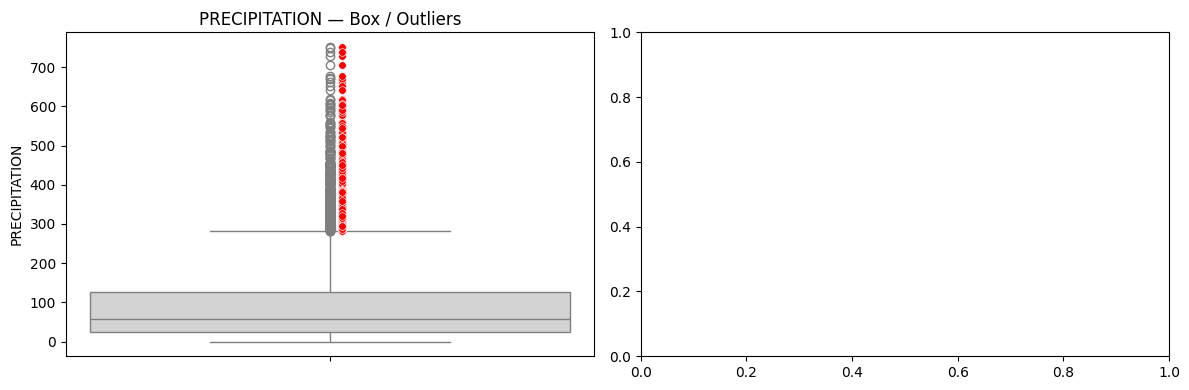

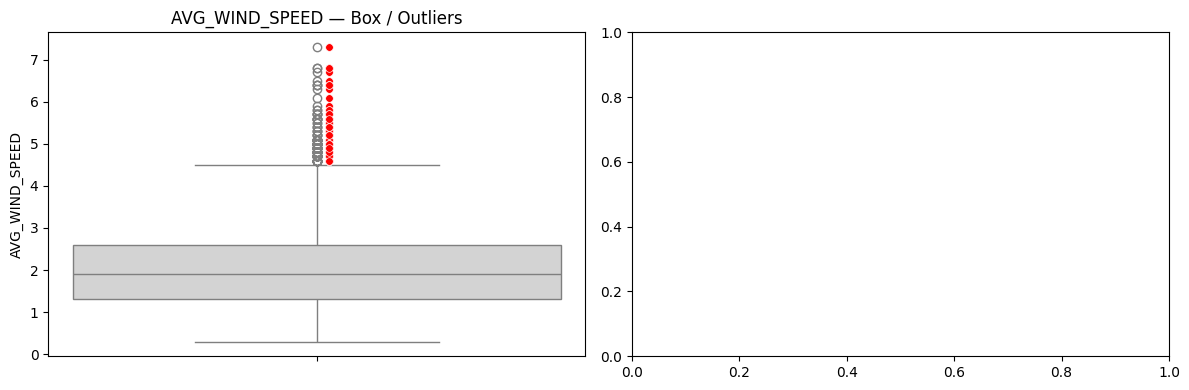

In [ ]:
# ── 0. 준비 ───────────────────────────────────────────────────
cols = ['PRECIPITATION', 'AVG_WIND_SPEED']   # 살펴볼 열
out_df = {}                     # 이상치만 담아둘 딕셔너리
bounds = {}                     # IQR 경계 저장용

# ── 1. 이상치 행 추출 ────────────────────────────────────────
for col in cols:
    q1, q3 = KBWeather_df[col].quantile([.25, .75])
    iqr    = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr    # Tukey fence (k=1.5)
    bounds[col] = (lo, hi)

    mask = (KBWeather_df[col] < lo) | (KBWeather_df[col] > hi)
    out_df[col] = KBWeather_df.loc[mask].copy()      # 이상치만 별도 보관

print("IQR bounds:", bounds)

# ── 2. 빠른 미리보기 ────────────────────────────────────────
for col, sub in out_df.items():
    print(f"\n==== {col} 이상치 {len(sub)}건 ====")
    display(sub[[col]].describe())        # 기초 통계
    display(sub[['DATE', col]].head())     # 상위 5행
    display(sub[['DATE', col]].tail())     # 하위 5행

# ── 3. 박스플롯 & 시계열 스캐터 ─────────────────────────────
for col, sub in out_df.items():
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    # (a) 전체 vs 이상치 박스플롯
    sns.boxplot(y=KBWeather_df[col], ax=axes[0], color='lightgray')
    sns.scatterplot(y=sub[col], x=np.zeros(len(sub))+0.02,
                    ax=axes[0], color='red', zorder=2, s=30)
    axes[0].set_title(f"{col} — Box / Outliers")

    # (b) 날짜별 스캐터
    if '일시' in sub.columns:
        sns.scatterplot(data=sub, x='DATE', y=col, ax=axes[1],
                        color='red', s=10)
        axes[1].set_title(f"{col} — Time scatter")

    plt.tight_layout()
    plt.show()

### 5. 연도, 월 나누기

In [ ]:
# ───────────────────────────────────────────────────────────────
# 'DATE' → YEAR / MONTH 분리
# ───────────────────────────────────────────────────────────────

# 1) 문자열을 날짜형으로 변환
#    - 포맷이 'YYYY-MM-DD'·'YYYY/MM/DD'·'YYYYMMDD' 등이어도
#      to_datetime 이 자동으로 인식합니다.
KBWeather_df['DATE'] = pd.to_datetime(KBWeather_df['DATE'], errors='coerce')

# 2) 연·월 추출해 새 열 만들기
KBWeather_df['YEAR']  = KBWeather_df['DATE'].dt.year
KBWeather_df['MONTH'] = KBWeather_df['DATE'].dt.month

# 3) 기존 'DATE' 열 제거
cols_to_drop = ['DATE']
KBWeather_df = KBWeather_df.drop(columns=cols_to_drop, errors='ignore')

# 4) 확인
print(KBWeather_df[['YEAR', 'MONTH']].head())


      YEAR  MONTH
1041  1971      1
1042  1971      2
1043  1971      3
1044  1971      4
1045  1971      5


## 아현


- 시군별 데이터를 연/월별 평균값으로 통일
- 월합강수량 → 일평균 강수량으로 변환
- 기온차(temp_range) 변수 생성 (최고기온 - 최저기온)

In [ ]:
df = KBWeather_df.copy()


# 2. temp_range 생성 (최고기온 - 최저기온)
df['temp_range'] = df['MAX_TEMP'] - df['MIN_TEMP']


# 3. 일평균 강수량 생성: 월강수량 / 일수
days_in_month = {
    1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30,
    7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31
}
df['DAYS'] = df['MONTH'].map(days_in_month)
df['daily_precip'] = df['PRECIPITATION'] / df['DAYS']

# 4. one-hot encoding
month_ohe = pd.get_dummies(df['MONTH'],
                           prefix='MONTH',
                           drop_first=False,
                           dtype='int8')

df = pd.concat([df, month_ohe], axis=1)


# 5. 연/월별 전체 시군 평균값 산출 (CITY 제외)
grouped_df = df.groupby(['YEAR', 'MONTH']).mean(numeric_only=True).reset_index()


# 6. 필요 없는 열 정리 (DAYS, PRECIPITATION)
df = grouped_df.drop(columns=['DAYS', 'PRECIPITATION'], errors='ignore')

In [ ]:
df.head()
df.tail()
print(df['YEAR'].min(), "~", df['YEAR'].max())

1949 ~ 2025


In [ ]:
# # 7. 파일 다운로드
# output_path = "/content/drive/MyDrive/Data Science Team Project/preprocessed_KB.csv"

# df.to_csv(output_path, index=False, encoding="utf-8-sig")

# print(f"파일이 저장되었습니다  →  {output_path}")

# 2차

*   1955년부터 학습 데이터로 사용
*   기준 연도(2000년) 변환: `YEAR_SINCE_2000 = YEAR - 2000` 생성
*   파생 피쳐 생성:` 'LINEAR_TEMP_TREND'`, `'YEAR_MONTH_INDEX'`, `'YEAR_SQUARED'`



### 1. 1955년부터 학습 데이터로 사용

In [ ]:
# 'YEAR' 컬럼의 값이 1955 이상인 행만 남김
df = df[df['YEAR'] >= 1955]

# 결과 확인
print(df.head())

    YEAR  MONTH  MAX_TEMP  MIN_TEMP  AVG_WIND_SPEED  temp_range  daily_precip  \
67  1955      1       3.7      -5.4             4.2         9.1      0.100000   
68  1955      2       8.6      -0.6             3.2         9.2      1.757143   
69  1955      3      11.3       3.7             3.1         7.6      1.641935   
70  1955      4      16.6       8.6             2.7         8.0      1.450000   
71  1955      5      21.4      13.4             2.0         8.0      1.329032   

    MONTH_1  MONTH_2  MONTH_3  MONTH_4  MONTH_5  MONTH_6  MONTH_7  MONTH_8  \
67      1.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
68      0.0      1.0      0.0      0.0      0.0      0.0      0.0      0.0   
69      0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   
70      0.0      0.0      0.0      1.0      0.0      0.0      0.0      0.0   
71      0.0      0.0      0.0      0.0      1.0      0.0      0.0      0.0   

    MONTH_9  MONTH_10  MONTH_11  MONTH_12  


### 2. 기준 연도(2000) 변환
"기준 연도로부터의 차이" 방식 도입


In [ ]:
df['YEAR_SINCE_2000'] = df['YEAR'] - 2000

# 결과 확인
print(df.head())

    YEAR  MONTH  MAX_TEMP  MIN_TEMP  AVG_WIND_SPEED  temp_range  daily_precip  \
67  1955      1       3.7      -5.4             4.2         9.1      0.100000   
68  1955      2       8.6      -0.6             3.2         9.2      1.757143   
69  1955      3      11.3       3.7             3.1         7.6      1.641935   
70  1955      4      16.6       8.6             2.7         8.0      1.450000   
71  1955      5      21.4      13.4             2.0         8.0      1.329032   

    MONTH_1  MONTH_2  MONTH_3  MONTH_4  MONTH_5  MONTH_6  MONTH_7  MONTH_8  \
67      1.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
68      0.0      1.0      0.0      0.0      0.0      0.0      0.0      0.0   
69      0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   
70      0.0      0.0      0.0      1.0      0.0      0.0      0.0      0.0   
71      0.0      0.0      0.0      0.0      1.0      0.0      0.0      0.0   

    MONTH_9  MONTH_10  MONTH_11  MONTH_12  Y

### 3. 연도 정보 반영을 위한 파생 피쳐 생성

1. **선형 추세 반영**

  시간이 흐를수록 기온이 선형적으로 상승한다는 도메인 기반 힌트 제공

In [ ]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(df[['YEAR_SINCE_2000']], df['MAX_TEMP'])
print(linreg.coef_)  # 연도당 기온 변화량(=기울기)

[0.01714123]


경북 데이터셋의 연도당 기온 변화량 추세를 반영

In [ ]:
df['LINEAR_TEMP_TREND'] = 0.017 * df['YEAR_SINCE_2000']

# 결과 확인
print(df.head())

    YEAR  MONTH  MAX_TEMP  MIN_TEMP  AVG_WIND_SPEED  temp_range  daily_precip  \
67  1955      1       3.7      -5.4             4.2         9.1      0.100000   
68  1955      2       8.6      -0.6             3.2         9.2      1.757143   
69  1955      3      11.3       3.7             3.1         7.6      1.641935   
70  1955      4      16.6       8.6             2.7         8.0      1.450000   
71  1955      5      21.4      13.4             2.0         8.0      1.329032   

    MONTH_1  MONTH_2  MONTH_3  ...  MONTH_5  MONTH_6  MONTH_7  MONTH_8  \
67      1.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
68      0.0      1.0      0.0  ...      0.0      0.0      0.0      0.0   
69      0.0      0.0      1.0  ...      0.0      0.0      0.0      0.0   
70      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
71      0.0      0.0      0.0  ...      1.0      0.0      0.0      0.0   

    MONTH_9  MONTH_10  MONTH_11  MONTH_12  YEAR_SINCE_2000  LINEAR_T

2. **월별 시간 흐름을 정수로 표현**

*   시계열처럼 시간 순서를 가진 정수 피처
- 시간적 연속성을 학습할 수 있게 도와줌



In [ ]:
df['YEAR_MONTH_INDEX'] = df['YEAR_SINCE_2000'] * 12 + df['MONTH']

# 결과 확인
print(df.head())

    YEAR  MONTH  MAX_TEMP  MIN_TEMP  AVG_WIND_SPEED  temp_range  daily_precip  \
67  1955      1       3.7      -5.4             4.2         9.1      0.100000   
68  1955      2       8.6      -0.6             3.2         9.2      1.757143   
69  1955      3      11.3       3.7             3.1         7.6      1.641935   
70  1955      4      16.6       8.6             2.7         8.0      1.450000   
71  1955      5      21.4      13.4             2.0         8.0      1.329032   

    MONTH_1  MONTH_2  MONTH_3  ...  MONTH_6  MONTH_7  MONTH_8  MONTH_9  \
67      1.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
68      0.0      1.0      0.0  ...      0.0      0.0      0.0      0.0   
69      0.0      0.0      1.0  ...      0.0      0.0      0.0      0.0   
70      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
71      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   

    MONTH_10  MONTH_11  MONTH_12  YEAR_SINCE_2000  LINEAR_TEMP_TREND

3. **비선형 시간 특성**
- 연도에 따른 기후 변화가 선형이 아닐 수 있다는 가정 반영
- 트리 모델이 더 다양한 split을 학습할 수 있도록 유도

In [ ]:
df['YEAR_SQUARED'] = df['YEAR_SINCE_2000'] ** 2

# 결과 확인
print(df.head())

    YEAR  MONTH  MAX_TEMP  MIN_TEMP  AVG_WIND_SPEED  temp_range  daily_precip  \
67  1955      1       3.7      -5.4             4.2         9.1      0.100000   
68  1955      2       8.6      -0.6             3.2         9.2      1.757143   
69  1955      3      11.3       3.7             3.1         7.6      1.641935   
70  1955      4      16.6       8.6             2.7         8.0      1.450000   
71  1955      5      21.4      13.4             2.0         8.0      1.329032   

    MONTH_1  MONTH_2  MONTH_3  ...  MONTH_7  MONTH_8  MONTH_9  MONTH_10  \
67      1.0      0.0      0.0  ...      0.0      0.0      0.0       0.0   
68      0.0      1.0      0.0  ...      0.0      0.0      0.0       0.0   
69      0.0      0.0      1.0  ...      0.0      0.0      0.0       0.0   
70      0.0      0.0      0.0  ...      0.0      0.0      0.0       0.0   
71      0.0      0.0      0.0  ...      0.0      0.0      0.0       0.0   

    MONTH_11  MONTH_12  YEAR_SINCE_2000  LINEAR_TEMP_TREND  YE

'MONTH', 'YEAR' 컬럼 삭제

In [ ]:
df = df.drop(columns=['MONTH', 'YEAR'], errors='ignore')

# 결과 확인
print(df.head())

    MAX_TEMP  MIN_TEMP  AVG_WIND_SPEED  temp_range  daily_precip  MONTH_1  \
67       3.7      -5.4             4.2         9.1      0.100000      1.0   
68       8.6      -0.6             3.2         9.2      1.757143      0.0   
69      11.3       3.7             3.1         7.6      1.641935      0.0   
70      16.6       8.6             2.7         8.0      1.450000      0.0   
71      21.4      13.4             2.0         8.0      1.329032      0.0   

    MONTH_2  MONTH_3  MONTH_4  MONTH_5  ...  MONTH_7  MONTH_8  MONTH_9  \
67      0.0      0.0      0.0      0.0  ...      0.0      0.0      0.0   
68      1.0      0.0      0.0      0.0  ...      0.0      0.0      0.0   
69      0.0      1.0      0.0      0.0  ...      0.0      0.0      0.0   
70      0.0      0.0      1.0      0.0  ...      0.0      0.0      0.0   
71      0.0      0.0      0.0      1.0  ...      0.0      0.0      0.0   

    MONTH_10  MONTH_11  MONTH_12  YEAR_SINCE_2000  LINEAR_TEMP_TREND  \
67       0.0       0

## train-test split

In [ ]:
# Train/Test 분리
train_df = df[(df['YEAR_SINCE_2000'] >= -45) & (df['YEAR_SINCE_2000'] <= 19)]
test_df  = df[(df['YEAR_SINCE_2000'] >= 20) & (df['YEAR_SINCE_2000'] <= 25)]

# 각각 CSV로 저장 (인덱스 제외)
train_path = root_dir + '/Data1_Train.csv'
test_path  = root_dir + '/Data1_Test.csv'

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path,  index=False)

# 저장 완료 로그
print(f"Train set: {train_df.shape[0]} rows → {train_path}")
print(f"Test  set: {test_df.shape[0]} rows → {test_path}")

Train set: 780 rows → /content/drive/MyDrive/Data Science Team Project/Data1_Train.csv
Test  set: 64 rows → /content/drive/MyDrive/Data Science Team Project/Data1_Test.csv
